# Lab 7: Time Series and Recurrent Neural Networks

In this lab, we will learn mainly about [**Recurrent Neural Networks**](https://en.wikipedia.org/wiki/Recurrent_neural_network) (or RNN, for short). RNNs expand the architectures we have encountered so far by allowing for feedback loops in time. This property makes RNNs particularly suited to work with ordered data, for example, time series, sound, and text. These networks can generate arbitrary sequences of outputs, opening the door on many new types of Supervised Learning problems.

Machine Learning on Time Series requires a bit more caution than usual since we need to avoid leaking future information into the training. We will start this lab talking about Time Series and Sequence problems in general. Then we will introduce RNNs and in particular two famous architectures: **LSTMs** and **GRUs** (for the latter, have a look at Exercise 2).


This lab contains both practical and theoretical parts with some math. Like we did in lab 5, let us first tell you: **you don't NEED to read the math in this lab**. This labs is for the developer and practitioner that is interested in applying Neural Networks to solve great problems. We provide the math for the curious, and we will make sure to highlight which sections you can skip at a first read.

## Time Series

Time series are everywhere. Examples of time series are the values of a stock, music, text, events on your app, video games, which are sequences of actions, and in general, any quantity monitored over time that generates a sequence of values.


![A time Series](./assets/time_series.png)

A time series is an ordered sequence of data points, and it can be univariate or multivariate.

A **univariate** time series is nothing but a sequence of scalars. Examples of this are temperature values through the day or the number of app downloads per minute.

A time series could also take values in a vector space, in which case it is a **multivariate** time series. Examples of vector time series are the speed of a car as a function of time or an audio file recorded in stereo, which has two channels.

Machine Learning can be applied to time series to solve several problems including forecasting, anomaly detection, and pattern recognition.

![Time Series Problems](./assets/time_series_problems.png)

**Forecasting** refers to predicting future samples in a sequence. In a way, this problem is a regression problem because we are predicting a continuous quantity using features derived from the time series and most likely it is a nonlinear regression.

**Anomaly detection** refers to identifying deviations from a regular pattern. We can approach this problem in two ways: if we know the anomalies we are looking for, we treat it as a binary classification problem between the anomalous and the regular class. If we do not know them, we train a model to forecast future values (regression) and then compare the predicted value and the original signal. In this case, anomalies are where the prediction is very different from the actual value in the time series.

**Pattern recognition** is classification on time series, identifying recurring patterns.

In all these cases we must use particular care because the data is ordered in time and we need to avoid leaking future information in the features used by the model. This is particularly true for model validation. If we split the time series into training and test sets, we cannot just pick a random split from the time series. We need to **split the data in time**: all the test data should come after the training data.

![Train/Test approach for a time series problem](./assets/train_test_time.png)

Also, sometimes a trend or a seasonal pattern is distinguishable. 

![Trend and seasonality](./assets/trend_periodicity.png)

This fact is recognizable in any data related to human activity, where **daily**, **weekly**, *monthly** and **yearly periodicities** are found. 

Think for example of retail sales. A dataset with hourly sales from a shop will have regular patterns during the day: with a period of higher customer flow and period of lower customer flow, as well as during the week. Depending on the type of goods we may find higher or lower sales during the weekend. Special dates, like black Friday or sales days, will appear as anomalies in these regular patterns and should be easy to catch. In these cases, it is a good idea to either remove these periodicities beforehand or to add the relevant time interval as an input feature.

## Time series classification

As a warm-up exercise let's perform a classification on time series data. Let's load the usual common files:

In [1]:
with open('common.py') as fin:
    exec(fin.read())

In [2]:
with open('matplotlibconf.py') as fin:
    exec(fin.read())

The file `sequence_classification.csv.bz2` contains a set of 4000 curves. Let's load it and look at a few rows and columns:

In [3]:
fname = '../data/sequence_classification.csv.bz2'
df = pd.read_csv(fname, compression='bz2')
df.iloc[0:5, 0:5]

,anomaly,t_0,t_1,t_2,t_3
0,False,1.000000,0.974399,0.939818,0.906015
1,True,0.626815,0.665145,0.669603,0.693649
2,False,0.983751,0.944806,0.999909,0.975756
3,True,0.977806,1.000000,0.975431,0.966523
4,False,0.691444,0.710671,0.660787,0.690993


>TIP: this is the first time that we load a zipped file, i.e., a compressed file convenient to save storage space. Pandas allows loading directly zipped file saved in several formats, for example, a `bz2` file. Have a look at the [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) for further details and discover all the formats supported.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 201 entries, anomaly to t_199
dtypes: bool(1), float64(200)
memory usage: 6.1 MB


Each row in the dataset is a curve, the labels for anomalies are given in the first column (in this case, we have two, `True` and `False`).

In [5]:
df['anomaly'].value_counts()

True     2000
False    2000
Name: anomaly, dtype: int64

As we can see, 2000 curves present anomalies, while the other 2000 do not. Let's create the `X` and `y` arrays and plot the first four curves.

In [6]:
X = df.drop("anomaly", axis="columns").values
y = df["anomaly"].values

Now let's plot these curves separated by the anomaly values.

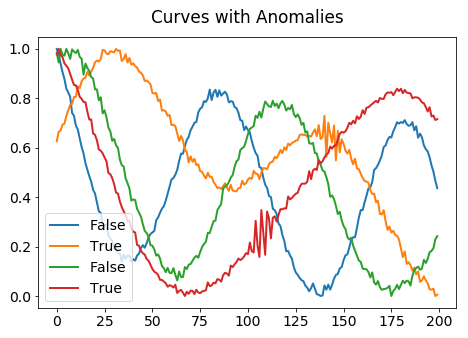

In [7]:
plt.plot(X[:4].transpose())
plt.legend(y[:4])
plt.title("Curves with Anomalies");

How do we treat this problem with Machine Learning?

We can approach it in various ways.

1. We could use the values of the curves as features (that is 200 points) and feed them to a fully connected network.
2. We could engineer features from the curves, like statistical quantities, differences, and Fourier coefficients and feed those to a Neural Network.
3. We could use a 1D convolutional network to extract patterns from the curves automatically.

Let's quickly try all three. 

> TIP: if you had to guess, which of the three approaches seems more promising?

First of all, we will perform a train/test split. In this case we do not need to worry about the order in time because the sequences are given to us without any information about their absolute time. For all we know they could be independent measurements of the same phenomenon.

Let's load the `train_test_split` function from `sklearn` first:

In [8]:
from sklearn.model_selection import train_test_split

Now let's split the data into the training and test sets:

In [9]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25,
                     random_state=0)

### Fully connected networks

Let's load the usual `Sequential` model and `Dense` layer from `tensorflow.keras` so we can build our fully connected network:

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

The model will take the 200 values that form a curve as independent input features and it will have a single output neuron to classify the curve as containing an anomaly or not.

This process should be pretty familiar by now:

In [11]:
model = Sequential([
    Dense(100, input_dim=200, activation='relu'),
    Dense(50, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Next, let's train the model to fit against our training set.

In [12]:
h = model.fit(X_train, y_train, epochs=30,
              verbose=0, validation_split=0.1)

Now, let's plot the curves of our newly trained model.

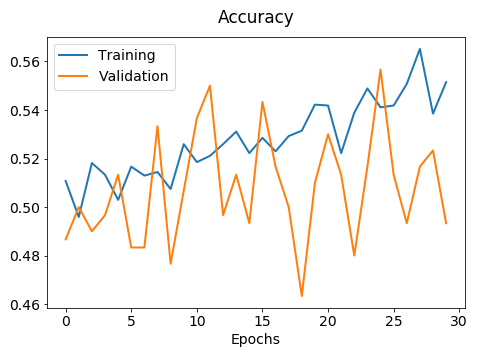

In [13]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs');

In [14]:
acc_ = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:0.3}".format(acc_))

Test Accuracy: 0.534


This model does not seem to perform well (operating around 50% accuracy). We can understand the reason of this poor performance if we notice that the anomaly can be located anywhere along the curve. Since every point in the curve is treated as an independent input feature, and each of them can contain an anomaly or not, it is difficult for the network to learn a consistent pattern about the presence of an anomaly simply by looking at amplitude values.

### Fully connected networks with feature engineering

Let's try to extract some features from the curves. We will limit ourselves to:

- `std`: standard deviation of the curve values
- `std_diff`: standard deviation of the first order differences

> TIP: feel free to add more features like higher order [statistical moments](https://en.wikipedia.org/wiki/Moment_%28mathematics%29) or [Fourier coefficients](https://en.wikipedia.org/wiki/Fourier_series#Definition).

First, let's build the new DataFrame `eng_f` containing in the two columns the feature `std` and `std_diff`.

In [15]:
eng_f = pd.DataFrame(X.std(axis=1), columns=['std'])
eng_f['std_diff'] = np.diff(X, axis=1).std(axis=1)

eng_f.head()

,std,std_diff
0,0.260902,0.023511
1,0.249588,0.030286
2,0.304086,0.023464
3,0.302908,0.030531
4,0.286405,0.066638


We split the data again:

In [16]:
(eng_f_train, eng_f_test,
 y_train, y_test) = train_test_split(eng_f.values, y,
                                    test_size=0.25,
                                    random_state=0)

Let's clear out the backend for any memory we've already used:

In [17]:
import tensorflow.keras.backend as K

In [18]:
K.clear_session()

Next, let's train a fully connected model: as already seen many times, the first layer depends on the number of input features. In this case we only have 2 inputs: `std` and `std_diff`. The last layer will still be a binary classification 0/1 in this contest (notice that the last layer is the same of the previous model, since we didn't change our output). The inner layers, only one in this model, depend on the researcher preference and are treated as hyperparameters.

In [19]:
model = Sequential([
    Dense(30, input_dim=2, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Now let's train our model on our 2 engineered features:

In [20]:
h = model.fit(eng_f_train, y_train, epochs=50,
              verbose=0, validation_split=0.1)

Let's plot the output of our model by plotting again:

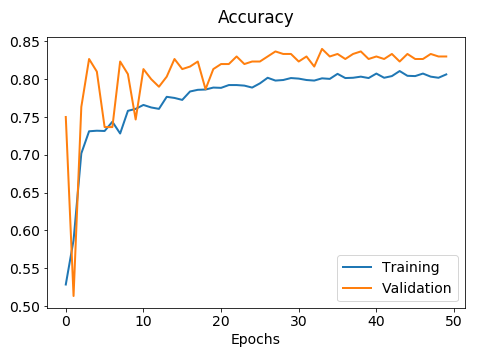

In [21]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs');

In [22]:
acc_ = model.evaluate(eng_f_test, y_test, verbose=0)[1]
print("Test Accuracy: {:0.3}".format(acc_))

Test Accuracy: 0.823


This model is already much better than the previous one, but can we do better? Let's try with the third approach, i.e. 1D convolutional network to automatically extract patterns from the curves.

### Fully connected networks with 1D Convolution

As we know by now, convolutional layers are good for recognizing spatial patterns. In this case we know the anomaly spans across a dozen points along the curve, so we should be able to capture it if we cascade a few `Conv1D` layers with filter size of 3.

> TIP: the filter size, 3 in this case, is an arbitrary choice. In the [Appendix](Appendix.ipynb#1D-Convolution-&-Correlation) we explain how a convolution with a filter size equal to 3 helps identify patterns in the 1D sequence. Cascading multiple layers with small filters allows us to learn longer patterns.

Furthermore, since the anomaly can appear anywhere along the curve, `MaxPooling1D` introduced in [Lab 6](6_Convolutional_Neural_Networks.ipynb#Pooling-layers) may help to reduce the sensitivity to the exact location. 

Finally we will need to include a few nonlinear activations, a `Flatten` layer (seen in [Lab 6](6_Convolutional_Neural_Networks.ipynb#Final-architecture)), and one or more fully connected layers. Let's do it!

First, let's import the relevant layers from the `tensorflow.keras` package:

In [23]:
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.layers import Flatten, Activation

Next, let's clear out the backend memory, just in case:

In [24]:
K.clear_session()

Next, let's build the model with our layers, considering again the 200 points as input:

In [25]:
model = Sequential([
    Conv1D(16, 3, input_shape=(200, 1)),
    Conv1D(16, 3),
    MaxPool1D(),
    Activation('relu'),

    Conv1D(16, 3),
    MaxPool1D(),
    Activation('relu'),

    Flatten(),

    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

`Conv1D` requires the input data to have shape (`N_samples`, `N_timesteps`, `N_features`) so we need to add a dummy dimension to our data.

In [26]:
X_train_t = X_train[:, :, None]
X_test_t = X_test[:, :, None]

Let's train our model over 30 epochs:

In [27]:
h = model.fit(X_train_t, y_train, epochs=30, verbose=0,
              validation_split=0.1)

Now let's plot the accuracy of our model using our 1D convolutional Neural Network:

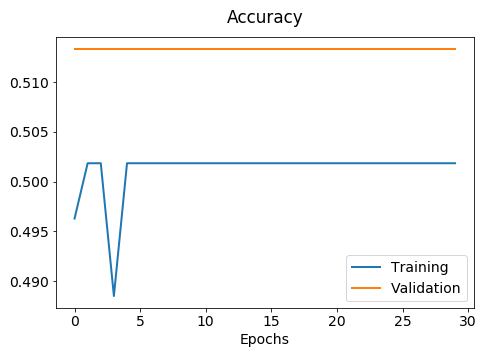

In [28]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs');

In [29]:
acc_ = model.evaluate(X_test_t, y_test, verbose=0)[1]
print("Test Accuracy: {:0.3}".format(acc_))

Test Accuracy: 0.491


This model is the best so far, and it required no feature engineering. We just reasoned about the type of patterns we were looking for and chose the most appropriate Neural Network architecture to detect them. This is very powerful!

## Sequence Problems

Time series problems can be extended to consider general problems involving sequences. In other words, we can consider a time series as a particular type of sequence, where every element of the sequence is associated with a  time. But, in general, we may have sequences of elements not associated with a specific time: for example, a word can be thought as a sequence of characters, or a sentence as a sequence of words. Similarly, the interactions of a user in an app form a sequence of events, and it is a very common use case to try to classify such a sequence or to predict what the next event is going to be.

More generally, we are going to introduce here a few general scenarios involving sequences, that will stretch our application of Machine Learning to new problems.

Let's start with 1-to-1 problems.

![Problems involving sequences](./assets/sequence_problems.png)

### 1-to-1

The simplest Machine Learning problem involving a sequence is the **1-to-1 problem**. All the Machine Learning problems we have encountered so far are of this type: linear regression, classification, and convolutional Neural Networks for image or sequence classification. **For each input we have one label**, for each image in MNIST we have a digit label, for each user, we have a purchase, for each banknote, we have a label of real or fake.

In all of these cases, the Machine Learning model learns a stateless function to connect a given input to a given output.

In the case of sequences, we can expand our framework to allow for the model to make use of past values of the input and the output. Let's see how.

### 1-to-many

The **1-to-many** problem starts like the 1-to-1 problem. We have an input, and the model generates an output. After the first output, the network continues to generate a sequence of outputs using its internal state or the previous output as input. We can continue like this indefinitely and therefore generate an arbitrary sequence of outputs.

A typical example of this situation is **image captioning**: a single image in input generates as output a text description of arbitrary length.

>TIP: a text description can be thought as a sequence either of words or characters. Every single words or character is indeed an element of the sequence.

### many-to-1

The **many-to-1** problem reverses the situation. We feed multiple inputs to the network, and at each step, we also feed the network output back into the network, until we reach the end of the input sequence. At this point, we look at the network output.

Text **sentiment analysis** falls in this category. We associate a single output sentiment label (positive or negative) to a string of text of arbitrary length in the input.

### asynchronous many-to-many

In the **asynchronous many-to-many** case, we have a sequence in input and a sequence in output. The model first learns to encode an input sequence of arbitrary length into the internal state. Then, when the sequence ends, the model starts to generate a new sequence.

The typical application for this setup is **language translation**, where an input sentence in a language, for example, English, is translated to an output sentence in a different language, for example, Italian. To complete the task correctly, the model has to "listen" to the whole input sentence first. Once the sentence is over, the model goes ahead and translates that into the new sentence.

### synchronous many-to-many

Finally, there's the **synchronous many-to-many** case, where the network outputs a value at each input, considering both the input and its previous state. **Video frame classification** falls in this category because for each frame we produce a label using the information from the frame but also the information from the state of the network.

### RNN allow graphs with cycles

**Recurrent Neural Networks** can deal with all these sequence problems because their connections form a directed cycle. In other words, they can retain state from one iteration to the next by using their output as input for the next step. This is similar to [infinite response filters](https://en.wikipedia.org/wiki/Infinite_impulse_response) in signal processing. 

In programming terms, this is like running a fixed program with defined inputs and some internal variables. Viewed this way, RNNs are networks that learn generic programs.

RNNs are **Turing-Complete**, which means they can simulate arbitrary programs! We can think of feed-forward Neural Networks as approximating arbitrary functions and Recurrent Neural Networks as approximating arbitrary programs. This makes them extremely powerful.

## Time series forecasting

We have seen how to solve some classification problems involving time series with Convolutional Neural Networks. 

The previous dataset, however, was quite unusual for many reasons. First of all, each sample sequence in the dataset had precisely the same duration, and each curve included exactly 200 timesteps. Secondly, we had no information about the order of the samples, and so we considered them as independent measurements and performed train/test split in the usual way. 

Both these conditions are not generally present when dealing with forecasting problems on time series or text data. A time series can have arbitrary length, and it usually comes with a timestamp, indicating the absolute time of each sample. 

Let's load a new dataset and let's see how recurrent networks can help in this case.

First of all we are going to load the dataset:

In [30]:
fname = '../data/ZonalDemands_2003-2016.csv.bz2'
df = pd.read_csv(fname, compression='bz2',
                 engine='python')

In [31]:
df.head(3)

,Date,Hour,Total Ontario,Northwest,...,Niagara,West,Tot Zones,diff
0,01-May-03,1,13702,809,...,617,1611,13865,163
1,01-May-03,2,13578,825,...,615,1564,13678,100
2,01-May-03,3,13411,834,...,596,1553,13534,123


In [32]:
df.tail(3)

,Date,Hour,Total Ontario,Northwest,...,Niagara,West,Tot Zones,diff
119853,2016/12/31,22,15195,495,...,465,1334,15790,595
119854,2016/12/31,23,14758,495,...,465,1334,15790,"1,032"
119855,2016/12/31,24,14153,495,...,465,1334,15790,"1,637"


The dataset contains hourly electricity demands for different parts of Canada and it runs from May 2003 to December 2016. Let's create a `pd.DatetimeIndex` using the `Date` and `Hour` columns.

In [33]:
def combine_date_hour(row):
    date = pd.to_datetime(row['Date'])
    hour = pd.Timedelta("%d hours" % row['Hour'])
    return date + hour

Let's run this function over our data to generate the `DatetimeIndex` for each column

In [34]:
idx = df.apply(combine_date_hour, axis=1)

In [35]:
idx.head()

0   2003-05-01 01:00:00
1   2003-05-01 02:00:00
2   2003-05-01 03:00:00
3   2003-05-01 04:00:00
4   2003-05-01 05:00:00
dtype: datetime64[ns]

In [36]:
df = df.set_index(idx)

>TIP: the function [`set_index()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.set_index.html) returns a new DataFrame whose index (row labels) has been set to the the values of one or more existing column. Unless you use the `inplace=True` argument this does not alter the DataFrame, it simply returns a different version. That's why we overwrite the original `df` variable.

Now that we have set the index, let's select and plot the `Total Ontario` column:

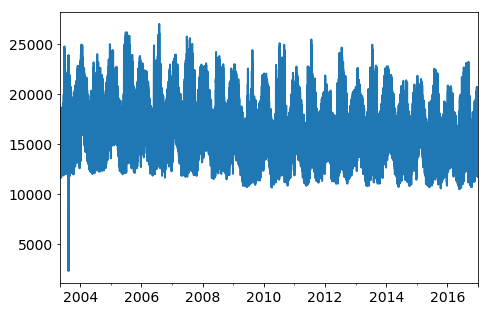

In [37]:
df['Total Ontario'].plot()

The time series seems quite regular, which looks promising for forecasting. Let's split the data in time on January 1st, 2014. We will use data before that date as training data and data after that date as test data.

In [38]:
split_date = pd.Timestamp('01-01-2014')

Now we copy the data to a pair of new Pandas data frames that only contain the `Total Ontario` data up to the split date (train) and after the split date (test).

In [39]:
train = df.loc[:split_date, ['Total Ontario']].copy()
test = df.loc[split_date:, ['Total Ontario']].copy()

> TIP: We use the `.copy()` command here because the `.loc` indexing command [may return a view on the data instead of a copy](http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy). This could be a problem later on when we do other selections or manipulations of the data.

Let's plot the data. We will use the matplotlib plotting function that is automatically aware of the index with dates and times and assign a label to each plot so that we can display them with a legend:

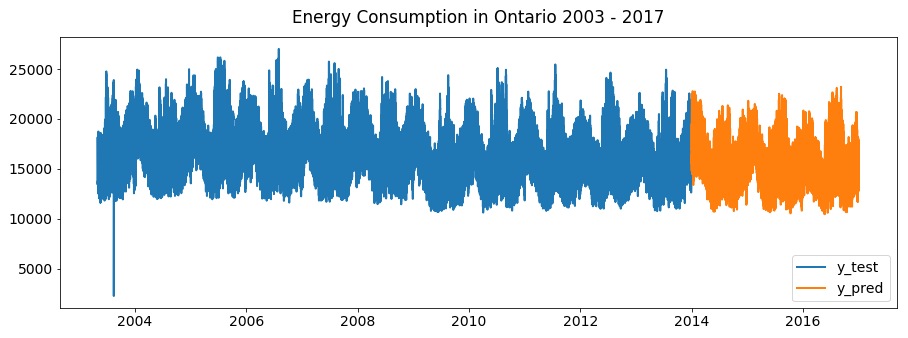

In [40]:
plt.figure(figsize=(15,5))
plt.plot(train, label='y_test')
plt.plot(test, label='y_pred')
plt.legend()
plt.title("Energy Consumption in Ontario 2003 - 2017");

We've already seen in [Lab 3](3_Machine_Learning.ipynb#Feature-Transformations) that Neural Network models are quite sensitive to the absolute size of the input features. Passing features with very large or minimal values will not help our model converge to a solution. Hence, we should rescale the data before anything else. 

Notice that there's a considerable drop somewhere in 2003. We shouldn't use that as the minimum for our analysis since it is an outlier.

We will rescale the data in such a way that most of it are close to 1. We can achieve this by subtracting 10000, which shifts everything down and then dividing by 5000.

> TIP: feel free to adjust these values as you prefer, or to try out other scaling methods like the `MinMaxScaler` or the `StandardScaler`. The important thing is to get our data close to 1 in size, not exactly between 0 and 1.

In [41]:
offset = 10000
scale = 5000

train_sc = (train - offset) / scale
test_sc = (test - offset) / scale

Let's look at the first four dates and demand to make sure our data is in the expected region of where we think it should be.

In [42]:
train_sc[:4]

,Total Ontario
2003-05-01 01:00:00,0.7404
2003-05-01 02:00:00,0.7156
2003-05-01 03:00:00,0.6822
2003-05-01 04:00:00,0.7002


Let's plot our entire dataset to confirm it matches our expectation.

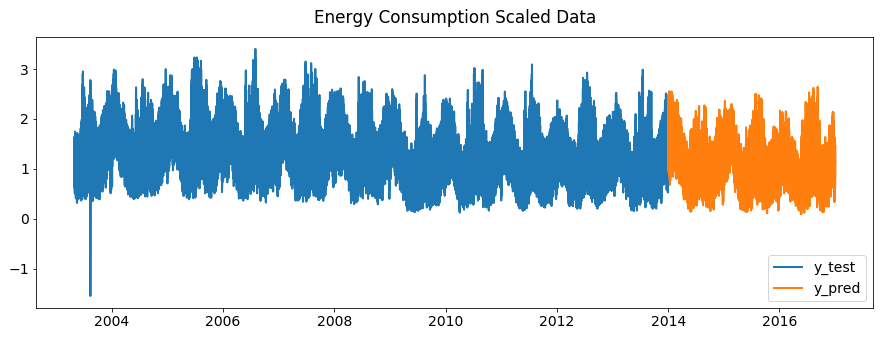

In [43]:
plt.figure(figsize=(15,5))
plt.plot(train_sc, label='y_test')
plt.plot(test_sc, label='y_pred')
plt.legend()
plt.title("Energy Consumption Scaled Data");

We are finally ready to build a predictive model. Our target is going to be the value of the energy demand at a certain point in time and our first model will try to predict such value from the value in the preceding hour. Our model will thus only have one feature, and the labels will come from the same data, shifted in time by one hour.

There is a neat trick to generate both labels and features from the same `train_sc` timeseries. This is achieved by taking every single point in the timeseries except the last one as features:

In [44]:
X_train = train_sc[:-1].values

and every single point starting from the second one untill the last one included as labels:

In [45]:
y_train = train_sc[1:].values

This creates two timeseries shifted by one hour, which will become the features and labels to our model. We repeat the same process with our test dataset:

In [46]:
X_test = test_sc[:-1].values
y_test = test_sc[1:].values

We can check a few input and output values by printing the first 5 points in `X_train` and `y_train`:

In [47]:
X_train[:5]

array([[0.7404],
       [0.7156],
       [0.6822],
       [0.7002],
       [0.802 ]])

In [48]:
y_train[:5]

array([[0.7156],
       [0.6822],
       [0.7002],
       [0.802 ],
       [1.0226]])

As you can see, the first value in `y_train` corresponds to the second value in `X_train`, meaning that we will be using the first value `X_train` to predict the next value and so on. Now we have our training data as well as testing data mapped out. Let's move on to model building.

### Fully connected network

Let's train a fully connected network to predict and see that it is not able to predict the next value from the previous one. 

The network will have a single input (the previous hour value) and a single output.

We can see this as a simple _regression problem_ since we want to establish a connection between two continuous variables. 

> TIP: if you need a refresher on what a regression is and why it makes sense to use it here, have a look at [Lab 3](3_Machine_Learning.ipynb#Linear-Regression) where we used a Linear regression to predict the weight of individuals given their height.

Since we want to predict a continuous variable, the output of the network does not need an activation function, and we will use the `mean_squared_error` as loss function, which is a standard error metric in regression models.

Let's clear the backend of any held memory first, as we have done many times when building a new model:

In [49]:
K.clear_session()

Next, let's build our model:

In [50]:
model = Sequential([
    Dense(24, input_dim=1, activation='relu'),
    Dense(12, activation='relu'),
    Dense(6, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In this case, before fitting the built Neural Networks, we load the `EarlyStopping` callback, to halt the training if it is not improving.

>TIP: a [callback](https://keras.io/callbacks/) is a set of functions to be applied at each epoch during the training. We have already encountered them in [Exercise 4 of Lab 5](5_Deep_Learning_Internals.ipynb#Exercise-4). You can pass a list of callbacks to the `.fit()` method, and in this specific case we use the `EarlyStopping` callback to stop the training if there is no progress. According to the [documentation](https://keras.io/callbacks/), `monitor` defines the quantity to be monitored (the `mean_squared_error` in this case) and `patience` defines the number of epochs with no improvement after which it will stop the training.

In particular, we will set the `EarlyStopping` callback to monitor the value of the loss and stop the training loop with a `patience=3` if that does not improve. Without this callback, the training will plateau on a fixed loss without improving, and the training will not stop by itself (go ahead and try to confirm that!).

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
early_stop = EarlyStopping(monitor='loss',
                           patience=3,
                           verbose=1)

Now we can launch the training, using this callback to monitor the progress of the data. 

Our dataset has over 100k points so we can choose large batches.

In [53]:
model.fit(X_train, y_train, epochs=200,
          batch_size=512, verbose=0,
          callbacks=[early_stop])

Epoch 00017: early stopping


The model stopped improving quite quickly. Feel free to experiment with other architectures and other activation functions. Let's see how our model is doing. We can generate the predictions on the test set by running `model.predict`.

In [54]:
y_pred = model.predict(X_test)

Let's visually compare test values and predictions:

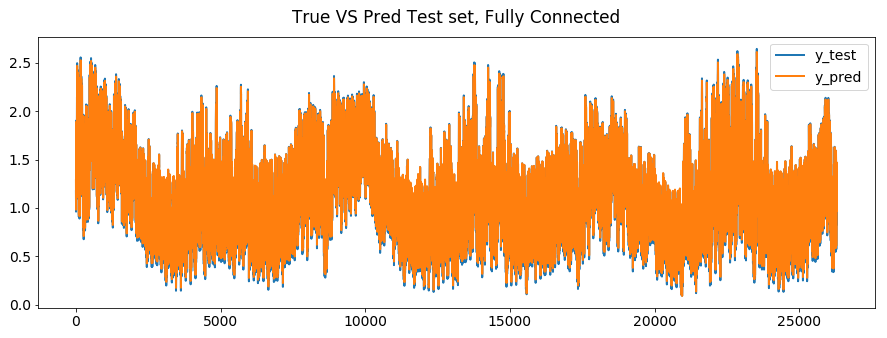

In [55]:
plt.figure(figsize=(15,5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.title("True VS Pred Test set, Fully Connected");

They seem to overlap pretty well. Is it so? Let's zoom in and watch more closely. We will do this by using the `plt.xlim` function that sets the boundaries of the horizontal axis in a plot. Feel free to choose other values to inspect other regions of the plot. Also, notice that we lost the date labels when we created the data, but this is not a problem: we can always bring them back from the original series if we need them.

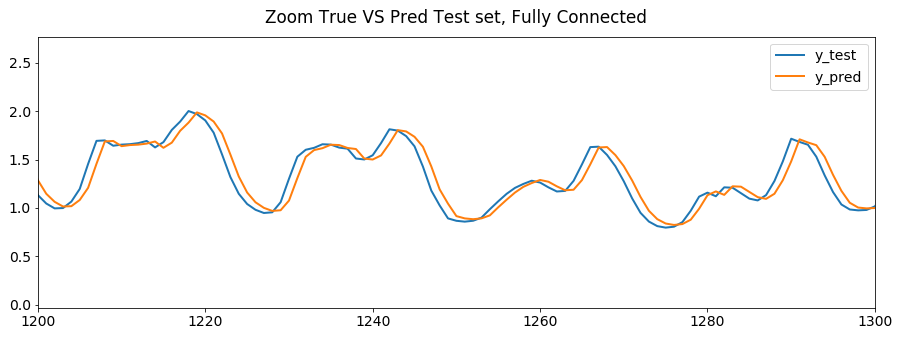

In [56]:
plt.figure(figsize=(15,5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.xlim(1200,1300)
plt.title("Zoom True VS Pred Test set, Fully Connected");

#### Fully connected network evaluation

Is this a good model? At first glance, we may be tempted to say it is.

Let's measure the total _mean squared error_ (a.k.a. our total loss) and the _$R^2$_ score on the test set. As seen in [Lab 3 here](3_Machine_Learning.ipynb#$R^2$-coefficient-of-determination)), if the _$R^2$_ score is far from 1.0, that is a sign of a bad regression.

> TIP: If you need a refresher about Mean Squared Error and  _$R^2$_ score, how they are defined and used, take a look at [Lab 3 here](./03_Machine_Learning.ipynb#Cost-Function)) and [Lab 3 here](./03_Machine_Learning.ipynb#$R^2$-coefficient-of-determination)

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [58]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: {:0.3}".format(mse))
print("R2: {:0.3}".format(r2))

MSE: 0.0151
R2: 0.932


In this case however the $R^2$ score is quite high, which would lead us to think the model is quite good.

**However, the model is not good at all!**

Why do we say that the model is not good at all? If you scrutinize the graph, you will realize that the network has just learned to _repeat the same value_ it receives in input!

This is not forecasting at all. In other words, the model has no real predictive power. It behaves like a parrot that repeats yesterday's value for today. In this particular case, since the curve is varying smoothly, the differences between one day and the next are small, and the  _$R^2$_ score is still pretty close to 1. However, the model is not anticipating any future value, and so it would be quite useless for forecasting. One easy way to see this is to measure the correlation between the predicted values and the correct labels, and then repeat the measure of correlation with labels shifted in time.

If the model was good at forecasting we expect the highest correlation to happen for a zero shift, with decreasing correlation when we shift the labels either forward or backward in time. Let's plug our test data into Pandas Series:

In [59]:
y_test_s = pd.Series(y_test.ravel())
y_pred_s = pd.Series(y_pred.ravel())

and now let's measure the correlation for a few values of the shift:

In [60]:
for shift in range(-5, 5):
    y_pred_shifted = y_pred_s.shift(shift)
    corr = y_test_s.corr(y_pred_shifted)
    print("Shift: {:2}, Corr: {:0.2}".format(shift, corr))

Shift: -5, Corr: 0.63
Shift: -4, Corr: 0.76
Shift: -3, Corr: 0.88
Shift: -2, Corr: 0.97
Shift: -1, Corr: 1.0
Shift:  0, Corr: 0.97
Shift:  1, Corr: 0.88
Shift:  2, Corr: 0.76
Shift:  3, Corr: 0.63
Shift:  4, Corr: 0.5


As you can see, the highest correlation for this model is found for a shift of -1, which validates our previous interpretation. The model is simply copying the input value to the output.

This behavior is not surprising. After all, the only feature our model knew was the value of the time series in the previous period, so it makes sense that the best it could do was to learn to repeat it as a prediction for what would come next.

Let's see if a recurrent network improves the situation.

### Recurrent Neural Networks

#### Vanilla RNN

As we introduced, Recurrent Neural Networks are able to maintain an internal state using feedback loops. Let's see how we could build a simple RNN.

The _Vanilla_ Recurrent Neural Network can be built as a fully connected Neural Network if we unroll the time axis.

![Unrolling time for a vanilla RNN](./assets/recurrent_2.png)

Ignoring the output of the network for the time being, let's focus on the recurrent aspect. The network is recurrent because it's internal state $h$ at time $t$ is obtained by mixing current input $x_t$ with the previous value of he internal state $h_{t-1}$:

\begin{equation}
h_t = \tanh(w \, h_{t-1} + u \, x_t)
\end{equation}

At each instant of time, the simple RNN is behaving as a fully connected network with two inputs: the current input $x_t$ and the previous output $h_{t-1}$. 

> TIP: Notice that for now, we are using a network with a single input and a single output, so both $x$ and $h$ are numbers. Later we will extend the notation to networks with multiple inputs and multiple recurrent units in a layer. As you will see the extension is quite simple.

Notice only two weights are involved: the weight multiplying the previous value of the output $w$ and the weight multiplying the current input $u$. By the way, doesn't this formula remind you of the [Exponentially Weighted Moving Average (or EWMA)](./Appendix.ipynb#EWMA)?

> TIP: we have already mentioned EWMA in [Lab 5](./05_Deep_Learning_Internals.ipynb#RMSProp:-Root-Mean-Square-Propagation-(or-Adagrad-with-EWMA)), and we explain it in the appendix. Just as a reminder, it's a simple smoothing algorithm that follows the formula: 
\begin{equation}
y_t = (1 - \alpha) \; y_{t-1} + \alpha \; x_t
\end{equation}
EWMA smooths a signal given by a sequence of data reducing its fluctuations.

It is not the same, because there is a _tanh_ and the two weights are independent but it does look similar: it's a linear mixing of the past output with the present input, followed by a nonlinear activation function.

Also, notice that the **weights do not depend on time**. The network is learning the best values of its two weights which don't change with time.

#### Deep Vanilla RNN

We can build deep recurrent Neural Networks by stacking recurrent layers onto one another. We feed the input to a first layer and then feed the output of that layer into a second layer and so on. Also, we can add multiple recurrent units in each layer. Each unit is receiving inputs from all the units in the previous layer (or the input) as well as all the units in the same layer at the previous time:

![Multiple RNN layers](./assets/deepRNN.png)


If we have multiple layers, we will need to make sure that an earlier layer returns the whole sequence of outputs to the next layer. This is achieved in Keras using the `return_sequences=True` optional argument when defining a layer. We will see an example of this in [Exercise 1](#Exercise-1).

Keras implements Vanilla Recurrent Layers with the `layers.SimpleRNN` class. Let's try it out on our forecasting problem. First of all we import it.

In [61]:
from tensorflow.keras.layers import SimpleRNN

The [documentation](https://keras.io/layers/recurrent/) for recurrent layers reads:

    Input shape

    3D tensor with shape (batch_size, timesteps, input_dim).

however, so far we have used only a tensor of second order for our data. Let's think about how to reshape our data because there's more than one way. Our input data right now has a shape of:

In [62]:
X_train.shape

(93551, 1)

So it's like a matrix with a single column. We want to add a dimension to the tensor so that the data is a tensor of order three. There are many ways of doing this, the simplest way is to reshape the tensor using the `.reshape` method. It's as if we were breaking our timeseries into a dataset of adjacent and disjoint windows and then pile all of them one on top of the other.

Let's define the window length to be 128 hours (a little over five days):

In [63]:
win_len = 128

Now we define a helper function that reshapes the data into a tensor of order three. Notice that this function will pre-pad our sequence with zeros since we need to make sure that the total length is divisible by `win_len`:

In [64]:
def reshape_tensor(x, l):
    orig_len = x.shape[0]
    n, r = divmod(orig_len, l)
    max_len = l * (n + 1)
    offset = max_len - orig_len
    new_array = np.zeros(max_len)
    new_array[offset:] = x.ravel()
    return new_array.reshape(n + 1, l, 1)

And let's test it on a short array with 10 elements, so that we understand its behavior:

In [65]:
example_array = np.arange(100,110)
example_array

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109])

In [66]:
example_t = reshape_tensor(example_array, 3)

The shape of `example_t` is:

In [67]:
example_t.shape

(4, 3, 1)

and if we check its content:

In [68]:
example_t

array([[[  0.],
        [  0.],
        [100.]],

       [[101.],
        [102.],
        [103.]],

       [[104.],
        [105.],
        [106.]],

       [[107.],
        [108.],
        [109.]]])

we see that the elements of the array are now arranged in adjacent in 4 sequences, of 3 elements each. Wonderful! Let's now convert our Train and Test sets:

In [69]:
X_train_t = reshape_tensor(X_train, win_len)
X_test_t = reshape_tensor(X_test, win_len)

y_train_t = reshape_tensor(y_train, win_len)
y_test_t = reshape_tensor(y_test, win_len)

Let's check the shape of our new variable `X_train_t`:

In [70]:
X_train_t.shape

(731, 128, 1)

Good! We reshaped the data to have one additional axis as requested. Notice that we reshaped the labels too, which may appear odd at first. In a few lines we will explain why.

First, let's think about the batches. If we want to pass the whole training set in order, we need to pass one sequence per batch and we need to pass the batches in order from the start of time.

In other words, we don't want to randomly sample batches from the sequence; we want to feed the windows one by one sequentially while maintaining the state of the network between one window and the next.

We can do this by setting the `stateful=True` argument in the layer, but it requires that the size of our data is exactly a multiple of the batch size.

Since we want to feed the points one by one, we will choose a `batch_size=1`. Let's do it!

Now let's create a `SimpleRNN` with one layer with six nodes, i.e., with six recurrent units in the layer. The principle is the same as above, only each of these units will receive a six-dimensional vector as recurrent input from the past, together with the single value of the actual input.

> TIP: The number of nodes here is arbitrary. We could choose to put many more nodes, but that would result in a bigger model which is slower to train. We have noticed that with six nodes results are acceptable, and hence we choose that value.

Notice that since we are using the `stateful=True` flag, we will need to pass the `batch_input_shape` to the first layer.

We will use the `Adam` optimizer (which is one of the most efficient and robust optimizer, as seen in [Lab 5](5_Deep_Learning_Internals.ipynb#Adam:-Adaptive-Moment-Estimation-(or-EWMA-everywhere)), adopting a small value for the learning rate, since the `SimpleRNN` can sometimes be unstable. 

In [71]:
from tensorflow.keras.optimizers import Adam, RMSprop

Let's clear the backend memory again:

In [72]:
K.clear_session()

Now let's build the model. We will pass a `batch_input_shape=(1, win_len, 1)` because we read the data one point at a time. Also we will set the input weights to one. We do this in order to reduce the variability in the results obtained, as you'll see, this model is quite unstable.

> TIP: if you get a result that is very different from the one of the labs, go ahead and re-initialize the model. It may be just a case of bad luck with the starting point in the minimization.

We need one last ingredient to create our model. As mentioned above, we have reshaped the labels as well as the inputs. This means that we will feed an input sequence and the model should return an output sequence to be compared with the sequence of values in the labels. See the figure:

![time_distributed.png](./assets/time_distributed.png)

This method of training RNNs is called (Teacher Forcing)[https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html]. To achieve this, we will use the `TimeDistributed` layer wrapper around our output `Dense` layer and we will instruct the `SimpleRNN` to return the whole sequence using the `return_sequences=True` instead of returning just the last output.

In [73]:
from tensorflow.keras.layers import TimeDistributed

In [74]:
model = Sequential()
model.add(SimpleRNN(6,
                    batch_input_shape=(1, win_len, 1),
                    kernel_initializer='ones',
                    return_sequences=True,
                    stateful=True))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer=Adam(lr=0.0005),
              loss='mean_squared_error')

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (1, 128, 6)               48        
_________________________________________________________________
time_distributed (TimeDistri (1, 128, 1)               7         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


Now we can fit the data. Since we are maintaining states between point, we shall pass the data in order using the `shuffle=False` flag and `batch_size=1`. Also, we run the training for a single epoch. In our experiments this should be sufficient to get decent results:

In [76]:
model.fit(X_train_t, y_train_t,
          epochs=3,
          batch_size=1,
          verbose=1,
          shuffle=False);

Epoch 1/3
731/731 [==============================] - 50s 68ms/sample - loss: 4.7793
Epoch 2/3
731/731 [==============================] - 48s 66ms/sample - loss: 0.4767
Epoch 3/3
731/731 [==============================] - 49s 67ms/sample - loss: 0.1389


Let's plot a small part of our predictive model to compare train and test. We will use the Numpy `.ravel()` method to flatten the tensors back into a unidimensional sequence:

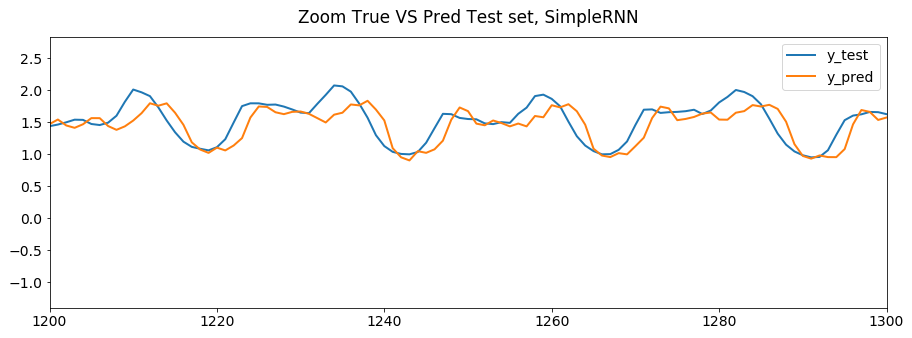

In [77]:
y_pred = model.predict(X_test_t, batch_size=1)
plt.figure(figsize=(15,5))
plt.plot(y_test_t.ravel(), label='y_test')
plt.plot(y_pred.ravel(), label='y_pred')
plt.legend()
plt.xlim(1200,1300)
plt.title("Zoom True VS Pred Test set, SimpleRNN");

While writing the labs we noticed that sometimes the model may converge to different solutions at each training run. 
1. Most often we get a graph that looks a little noisy but it is close to the actual data in the sharp decay phases, meaning some forecasting power is achieved:
![](./assets/simpleRNN_1.png)
2. Sometimes we would get a graph that looks very similar to the Fully Connected result, with no predictivity at all:
![](./assets/simpleRNN.png)
3. Sometimes the network will get stuck and give nonsense results like this one:
![](./assets/simpleRNN_2.png)

Feel free to change the number of layers, nodes, optimizer and learning rate to see if you can get better results. You will notice that this model is very prone to diverging away from a small value of the loss, which is not ideal at all.

Let's also check  _MSE_  and the $R^2$ score:

In [78]:
mse = mean_squared_error(y_test_t.ravel(), y_pred.ravel())
r2 = r2_score(y_test_t.ravel(), y_pred.ravel())

print("MSE: {:0.3}".format(mse))
print("R2: {:0.3}".format(r2))

MSE: 0.057
R2: 0.748


And let's also repeat the correlation with time-shift measure:

In [79]:
y_test_s = pd.Series(y_test_t.ravel())
y_pred_s = pd.Series(y_pred.ravel())

for shift in range(-5, 5):
    y_pred_shifted = y_pred_s.shift(shift)
    corr = y_test_s.corr(y_pred_shifted)
    print("Shift: {:2}, Corr: {:0.2}".format(shift, corr))

Shift: -5, Corr: 0.55
Shift: -4, Corr: 0.69
Shift: -3, Corr: 0.83
Shift: -2, Corr: 0.92
Shift: -1, Corr: 0.93
Shift:  0, Corr: 0.87
Shift:  1, Corr: 0.77
Shift:  2, Corr: 0.64
Shift:  3, Corr: 0.51
Shift:  4, Corr: 0.38


If you obtained a graph like the one in Case 1 above, you should get a lower MSE and the highest correlation for a shift of 0. On the other hand, if you obtained a graph like Case 2 above, you should obtain similar MSE and correlation values as to the Fully connected case.

All in all this model seems a little unstable. The problem probably lies with the fact that the `SimpleRNN` actually has a short memory and cannot learn long-term patterns.

Let's see why this happens and how we can fix it.

### Recurrent Neural Network Maths

![](./assets/warning_math.png)

To fully understand how recurrent networks work and why our simple implementation fails we will need a little bit of maths. Like we suggested in [Lab 5](./05_Deep_Learning_Internals.ipynb) you can feel free to skip this section entirely if you want to get to the working model. You can always come back to it later on if you are curious about how a recurrent network works.


#### Vanishing Gradients

Let's start from the equation of backpropagation through time, and let's ignore the output of the network for now and let's focus on the recurrent part. This is also called an **encoder network**, since we discard the output.

![Encoder Network](./assets/encoder.png)

This network is encountered in many cases, for example when solving many-to-1 problems like sentiment analysis or asynchronous many-to-many problems like machine translation.

Let's rewrite the recurrent relations, that in this case are:

\begin{align}
z_t & = w \, h_{t-1} + u \, x_t \\
h_t & = \phi(z_t) \\
\end{align}

where we substituted the $\tanh$ activation function to a generic activation $\phi$.

We can now use the [_overline_ notation introduced in Lab 5](./05_Deep_Learning_Internals.ipynb#Weight-updates) to study the backpropagation through time.

If we assume to have already backpropagated from the output all the way back to the error signal $\overline{h_T}$, we can write the backpropagation relations as:

\begin{align}
\overline{h_t} & = \overline{z_{t+1}} \,w \\
\overline{z_t} & = \overline{h_t} \,\phi'(z_t) \\
\end{align}


Let's focus our attention on $\overline{h_t}$, and let's propagate back all the way to $\overline{h_0}$:

\begin{align}
\overline{h_0} & = w \overline{z_1} \\
& = w \overline{h_1} \phi'(z_1) \\
& = w^2 \overline{h_2} \phi'(z_1) \phi'(z_2) \\
...
& = w^T \overline{h_T} \phi'(z_1) \phi'(z_2) ... \phi'(z_T) \\
\end{align}

Now remembering the definition of $\overline{h} = \frac{\partial J}{\partial h}$ we can write:

\begin{equation}
\overline{h_0} = \overline{h_T} \frac{\partial h_T}{\partial h_0}
\end{equation}

which implies:
\begin{equation}
\frac{\partial h_T}{\partial h_0} = w^T \phi'(z_1) \phi'(z_2) ... \phi'(z_T)
\end{equation}


Now let's stop for a second and focus on $\phi'(z)$. For most activation functions (_sigmoid_, _tanh_, _relu_) this quantity is **bounded**. This is easily seen looking at the graph of the derivative of these functions:

First, let's define the `sigmoid` and `relu` functions:

In [80]:
x = np.linspace(-10, 10, 1000)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def relu(x):
    cond = x > 0
    return cond * x

Let's plots for the `sigmoid`, the `Tanh`, and the `relu` activation functions along with their derivatives.

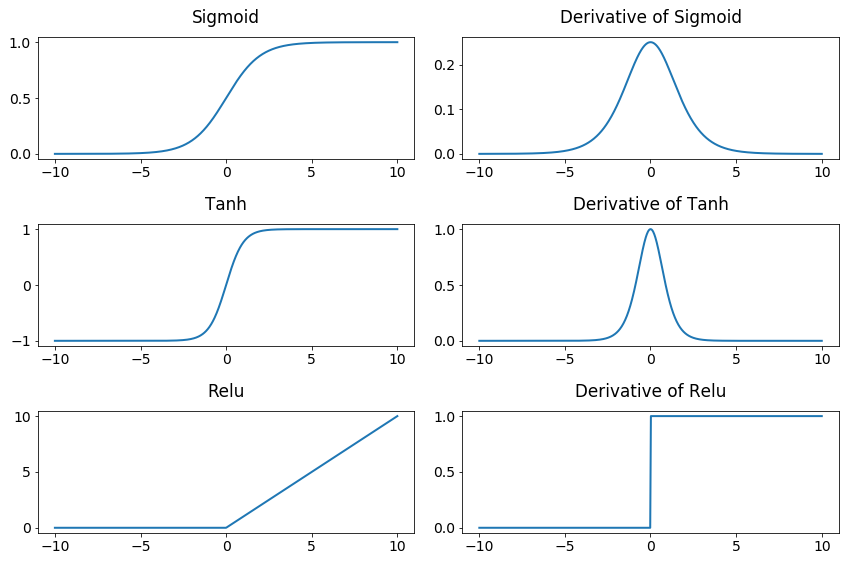

In [81]:
plt.figure(figsize=(12,8))
plt.subplot(321)
plt.plot(x, sigmoid(x))
plt.title('Sigmoid')

plt.subplot(322)
plt.plot(x[1:], np.diff(sigmoid(x))/np.diff(x))
plt.title('Derivative of Sigmoid')

plt.subplot(323)
plt.plot(x, np.tanh(x))
plt.title('Tanh')

plt.subplot(324)
plt.plot(x[1:], np.diff(np.tanh(x))/np.diff(x))
plt.title('Derivative of Tanh')

plt.subplot(325)
plt.plot(x, relu(x))
plt.title('Relu')

plt.subplot(326)
plt.plot(x[1:], np.diff(relu(x))/np.diff(x))
plt.title('Derivative of Relu')

plt.tight_layout()

All the derivatives take values between 0 and 1, i.e. they are **bounded**. We can use this fact to rewrite the last equation as:

\begin{equation}
\frac{\partial h_T}{\partial h_0} = w^T \phi'(z_1) \phi'(z_2) ... \phi'(z_T) \leq w^T 
\end{equation}

which means that the derivative of the last output with respect to the first output is less than or equal to $w^T$.

At this point, the vanishing gradient problem should be evident. If $w < 1$ the propagation through time is suppressed at each additional time step. The influence of an input that is three steps back in time will contribute to the gradient with a term smaller than $w^3$. If, for example, $w=0.1$, the previous point will contribute with less than 10%, the one before with less than 1% and the one before with 0.1% and so on. You can see that their contributions quickly disappear.

Let's take a peek at what this looks like visually. First, let's create a decay function that we'll use to create our plots.

In [82]:
def decay(w, T):
    t = np.arange(T)
    b = w**t
    return t, b

Now let's plot the quantity $w^T$ as a function of $T$ for several values of $w$:

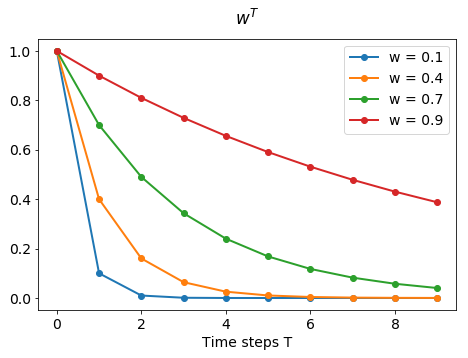

In [83]:
ws = [0.1, 0.4, 0.7, 0.9]
for w in ws:
    t, b = decay(w, 10)
    plt.plot(t, b, 'o-')

plt.title("$w^T$")
plt.xlabel("Time steps T")
plt.legend(['w = {}'.format(w) for w in ws]);

The error signal quickly goes to zero if the recurrent weight is smaller than 1. This suggests that the recurrent model is only able to capture short time dependencies, but longer dependencies are rendered useless. 

Similarly, we can show that when $w$ is greater than a certain threshold, the gradient will exponentially explode over time (notice that in the gradient we have $w^T$), rendering the backpropagation unstable.

It would appear as if we are stuck with a model that either does not converge at all or it quickly forgets about the past. How can we solve this?

### Long Short-Term Memory Networks (LSTM)

[LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) were designed to overcome the problems of simple Recurrent Networks by allowing the network to store data in a sort of memory that it can access at later times. LSTM units are a bit more complicated than the nodes we have seen so far, so let's take our time to understand what this means and how they work.

Again, feel free to skip this section at first and come back to it later on.

We will start from an intuitive description of how LSTM works, and we will gradually approach the mathematical formulas. We will do this because the formulas for the LSTM can be daunting at first, so it is good to break them down and learn them gradually.

At the core of the LSTM is the **internal state** $\mathbf{c}_t$. This state is like an internal conveyor belt that carries information from one time step to the next. In the general case, this is a vector, with as many entries as the number of units in the LSTM layer. The LSTM unit will store information in this vector, and this information will be available for retrieval later on.

![](./assets/lstm_c.png)

At time $t$ the LSTM block receives 2 inputs: 

* the new data at time $t$, which we indicate as $\mathbf{x}_t$ 
* the previous output at time $t-1$ which we indicate as  $\mathbf{h}_{t-1}$. 

We concatenate these two inputs to create a unique set of input feature. 

For example, if the input vector has length 3 (i.e., there are three input features) and the output vector has length 2 (i.e., there are two output features), the concatenated vector has now five features, three coming from the input vector and two coming from the output vector.

![](./assets/lstm_concat.png)

The next step is to apply four different simple Neural Network layers to these concatenated features along four parallel branches. Each branch takes a copy of the features and multiplies them by an independent set of weights and a different activation function.

> TIP: You may be wondering why 4 and not 3 or 5. The reason is simple: one branch is the one that will process the data similarly to the `Vanilla RNN`, i.e., it will take the past and the present, weight them and send them through a `tanh` activation function. The other three branches will control operations that we call **gates**. As you will see, these gates control how the internal state stores past and present information. Other kinds of recurrent units, like GRU, use a different number of gates, so four is specific to the LSTM architecture.

![](./assets/lstm_w.png)

Notice that the weights here are matrices. The number of rows in the weight matrix corresponds to the number of features, while the number of columns corresponds to the number of output features, i.e., the number of nodes in the LSTM layer.

After the matrix multiplication with the weights, the results go through four independent nonlinear activation functions.

![](./assets/lstm_sig.png)

Three of these are sigmoids, yielding the output vectors with values between 0 and 1. These three outputs take the name of **gates** because they control the flow of information. The last one is not a sigmoid; it is a $\tanh$.

Let's now look at the role of each of these nonlinear outputs. We start from the bottom one: the **forget gate**.

![](./assets/lstm_f.png)

The role of the forget gate is to mediate how much of the internal state vector to keep and pass through to future times. Since the value of this gate comes from a dense layer followed by a sigmoid, the LSTM node is learning which fraction of the past data to retain and which fraction to forget.

Notice that the $\odot$ operator implies we are multiplying $\mathbf{f}_t$ and $\mathbf{c}_t$ elementwise. This fact also means they are vectors of the same length.

Let's look at the gate mediated by $\mathbf{w}_i$. This gate is the **input gate** and it mediates how much of the input to keep. However, it's not the plain input concatenated vector; it's a vector that went through the $\tanh$ layer. We call it $\mathbf{g}_t$.

![](./assets/lstm_i.png)

This gating operation is also performed elementwise on $\mathbf{g}_t$.

We add the resulting vector $\mathbf{i}_t \odot \mathbf{g}_t$ to the fraction of internal state retained through the forget gate.

![](./assets/lstm_iplus.png)

The new internal state $\mathbf{c}_t$ is the result of these two operations: forgetting a bit of the past state and adding some new elements coming from the input and the past output.

Now that we have the update rules for the internal state let's see how to calculate the output state from the internal state. One last $\tanh$ operation

![](./assets/lstm_tanh.png)

Now let's look at the **output gate** $\mathbf{o}_t$. This gate mediates the output of the $\tanh$ only allowing part of it to escape to the output.

![The complete LSTM network graph](./assets/lstm.png)

There we go! It looks complex, but that's because it's one of the most complicated units in Neural Networks.

We've just dissected the LSTM block that has revolutionized our ability to tackle problems with long term dependencies. For example, LSTM blocks have been successfully used to learn the structure of language, to produce code from text descriptions, to translate between language pairs and so on.

For the sake of completeness, we will write here the equations of the LSTM, though it's not so important that you learn them: Keras has them implemented in a conveniently available `LSTM` layer!

\begin{align}
\mathbf{\aleph}_t & = [\mathbf{x}_t, \mathbf{h}_{t-1}] \\
\mathbf{i}_t & = \sigma(\mathbf{\aleph}_t \, . \mathbf{W}_i)\\
\mathbf{f}_t & = \sigma(\mathbf{\aleph}_t \, . \mathbf{W}_f)\\
\mathbf{o}_t & = \sigma(\mathbf{\aleph}_t \, . \mathbf{W}_o)\\
\mathbf{g}_t & = \tanh(\mathbf{\aleph}_t \, . \mathbf{W}_g)\\
\mathbf{c}_t & = \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \mathbf{g}_{t} \\
\mathbf{h}_t & = \mathbf{o}_t \odot \tanh(\mathbf{c}_{t}) \\
\end{align}


![](./assets/warning_math_done.png)

### LSTM forecasting

Enough with math and theory! Let's try to use an LSTM and see if we get a better result on our forecasting problem.

Let's import the `LSTM` layer from `tensorflow.keras`:

In [84]:
from tensorflow.keras.layers import LSTM

Let's clear the backend memory again to build our model:

In [85]:
K.clear_session()

Now let's build our model using the `LSTM` layer now. 

> TIP: according to the [documentation](https://keras.io/layers/recurrent/#lstm), the `LSTM` layer may have many arguments. In this case, we create a layer with six recurrent nodes, like we had six units in our fully connected layer and we will set `batch_input_shape=(1, 1, 1)` and `stateful=True`, i.e., the last state for each data point will be used as initial state next data point.

Like we did above, we will use the `Adam` optimizer with a small learning rate and initialize the input weights to one:

In [86]:
model = Sequential()
model.add(LSTM(6,
               batch_input_shape=(1, win_len, 1),
               kernel_initializer='ones',
               return_sequences=True,
               stateful=True))
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.0005) )

Now let's train our model. In doing so, we will use the `X_train_t` and `y_train_t` set for the training, the already specified `batch_size=1`, because we feed the data one point at a time, and `shuffle=False` to pass the data in order. We train the model for two epochs.

In [87]:
model.fit(X_train_t, y_train_t,
          epochs=5,
          batch_size=1,
          verbose=1,
          shuffle=False);

Epoch 1/5
731/731 [==============================] - 4s 6ms/sample - loss: 0.1300
Epoch 2/5
731/731 [==============================] - 4s 5ms/sample - loss: 0.0283
Epoch 3/5
731/731 [==============================] - 4s 5ms/sample - loss: 0.0134
Epoch 4/5
731/731 [==============================] - 4s 5ms/sample - loss: 0.0091
Epoch 5/5
731/731 [==============================] - 4s 5ms/sample - loss: 0.0070


The `LSTM` takes much longer to train than `SimpleRNN` because it has many more weights to adjust. In a future lab, we will learn how to use GPUs to speed up the training.

To examine the effectiveness of our model, and as we did before, we can plot a small part of the time series and compare our predictions with the true values:

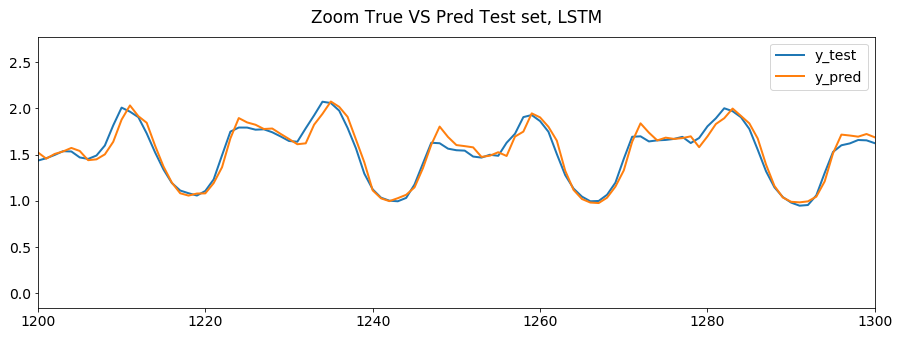

In [88]:
y_pred = model.predict(X_test_t, batch_size=1, )
plt.figure(figsize=(15,5))
plt.plot(y_test_t.ravel(), label='y_test')
plt.plot(y_pred.ravel(), label='y_pred')
plt.legend()
plt.xlim(1200,1300)
plt.title("Zoom True VS Pred Test set, LSTM");

This should look better than what we have obtained previously, but even in this case, we see that the ability of the network to forecast is limited. As done for the other models, let's also check the _Mean Squared Error_ and the _$R^2$_, for an objective evaluation of the error:

In [89]:
mse = mean_squared_error(y_test_t.ravel(), y_pred.ravel())
r2 = r2_score(y_test_t.ravel(), y_pred.ravel())

print("MSE: {:0.3}".format(mse))
print("R2: {:0.3}".format(r2))

MSE: 0.00616
R2: 0.973


and the correlation with time-shift measure:

In [90]:
y_test_s = pd.Series(y_test_t.ravel())
y_pred_s = pd.Series(y_pred.ravel())

for shift in range(-5, 5):
    y_pred_shifted = y_pred_s.shift(shift)
    corr = y_test_s.corr(y_pred_shifted)
    print("Shift: {:2}, Corr: {:0.2}".format(shift, corr))

Shift: -5, Corr: 0.52
Shift: -4, Corr: 0.65
Shift: -3, Corr: 0.79
Shift: -2, Corr: 0.91
Shift: -1, Corr: 0.98
Shift:  0, Corr: 0.99
Shift:  1, Corr: 0.93
Shift:  2, Corr: 0.83
Shift:  3, Corr: 0.71
Shift:  4, Corr: 0.58


As you can see, the maximum correlation is obtained for a shift of 0, which is a good indication that the model has some forecasting power.

## Improving forecasting

In all the models used so far, we fed the data sequentially to our recurrent unit, one point at a time. We can train a recurrent layer in other ways, for example, using the [rolling Windows approach](https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html).

![Rolling windows](./assets/rolling_windows.png)

Instead of taking a single previous point as input, we can use a set of points, going back in time for a window. This will allow us to feed data to the network in larger batches, speeding up training and hopefully improving convergence.

We will reformat our input tensor `X` to have the following shape: `(N_windows, window_len, 1)`. By doing this, we treat the time series as if many independent windows of fixed length composed it and we can treat each window as an individual data point. This has the advantage of allowing to randomize the Windows in our train and test data.

Let's start by defining the window size. We'll take a window of 24 periods, i.e., the data from the previous day. You can always adjust this later on if you wish:

In [91]:
window_len = 24

Next, we'll use the `.shift` method of a pandas DataFrame to create lagged copies of our original time series. Note that we will start from the `train_sc` and `test_sc` vectors we've defined earlier. Let's double check that they still contain what we need:

In [92]:
train_sc.head()

,Total Ontario
2003-05-01 01:00:00,0.7404
2003-05-01 02:00:00,0.7156
2003-05-01 03:00:00,0.6822
2003-05-01 04:00:00,0.7002
2003-05-01 05:00:00,0.8020


To create the lagged data we define a helper function `create_lagged_Xy_win` that creates an input matrix `X` with lags going from `start_lag + window_len - 1` to `start_lag` and an output vector `y` with the unaltered values.

So for example if we call: `create_lagged_Xy_win(train_sc, start_lag=24, window_len=168)` this will return a dataset `X` where periods run from 8 days before to 24 hours before the corresponding value in `y`.

Let's do it:

In [93]:
def create_lagged_Xy_win(data, start_lag=1,
                         window_len=1):
    X = data.shift(start_lag + window_len - 1).copy()
    X.columns = ['T_{}'.format(start_lag + window_len - 1)]

    if window_len > 1:
        for s in range(window_len, 0, -1):
            col_ = 'T_{}'.format(start_lag + s - 1)
            X[col_] = data.shift(start_lag + s - 1)

    X = X.dropna()
    idx = X.index
    y = data.loc[idx]
    return X, y

Now we use the function on the train and test data. We will use `start_lag=1` and `window_len=24` so that we can compare the results with our previous results:

In [94]:
start_lag=1
window_len=24

X_train, y_train = create_lagged_Xy_win(train_sc,
                                        start_lag,
                                        window_len)

X_test, y_test = create_lagged_Xy_win(test_sc,
                                      start_lag,
                                      window_len)

Let's take a look at our data:

In [95]:
X_train.head()

,T_24,T_23,T_22,T_21,...,T_4,T_3,T_2,T_1
2003-05-02 01:00:00,0.7404,0.7156,0.6822,0.7002,...,1.5408,1.3096,1.0414,0.8694
2003-05-02 02:00:00,0.7156,0.6822,0.7002,0.8020,...,1.3096,1.0414,0.8694,0.7742
2003-05-02 03:00:00,0.6822,0.7002,0.8020,1.0226,...,1.0414,0.8694,0.7742,0.7218
2003-05-02 04:00:00,0.7002,0.8020,1.0226,1.3524,...,0.8694,0.7742,0.7218,0.6914
2003-05-02 05:00:00,0.8020,1.0226,1.3524,1.5536,...,0.7742,0.7218,0.6914,0.7018


In [96]:
y_train.head()

,Total Ontario
2003-05-02 01:00:00,0.7742
2003-05-02 02:00:00,0.7218
2003-05-02 03:00:00,0.6914
2003-05-02 04:00:00,0.7018
2003-05-02 05:00:00,0.7904


As you can see, to predict the value 0.7806 that appears in `y` at `2003-05-08 05:00:00`, in `X` we have the previous values, going back in time from 0.6950 (previous hour) to 0.6734 (two hours before) and so on.

To feed this data to a recurrent model, we need to reshape as a tensor of order with the shape ` (batch_size, timesteps, input_dim)`. We are still dealing with a univariate time series, so  `input_dim=1`, while `timesteps` is going to be 168, the number of timesteps in the window. Easy to do using the [`.reshape` method from numpy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html).

We will get numpy arrays using the `.values` attribute. We have already checked that the data is shifted correctly, so it's not a problem to throw away the index and the column names:

In [97]:
X_train_t = X_train.values.reshape(-1, window_len, 1)
X_test_t = X_test.values.reshape(-1, window_len, 1)

y_train_t = y_train.values
y_test_t = y_test.values

Let's check the shape of our tensor is correct:

In [98]:
X_train_t.shape

(93528, 24, 1)

Yes! We have correctly reshaped the tensor. Note here that if we had multiple time series, we could have bundled them together in an input vector along the last axis.

Let's build a new recurrent model. This time we will not need to use the `stateful=True` setting because some history is already present in the input data and the windows are overlapping. For the same reason, we will use `input_shape` instead of `batch_input_shape`.

Also, since we will use batches of more than one point, and each point contains much history, the model convergence will be a lot more stable. Therefore we can increase the learning rate a lot without risking that the model becomes unstable.

Finally, notice that we are not going to be using the `TimeDistributed` wrapper here, since we didn't create output sequences (i.e. no Teacher Forcing):

In [99]:
K.clear_session()
model = Sequential()
model.add(LSTM(6, input_shape=(window_len, 1),
               kernel_initializer='ones'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.05) )

Let's go ahead and train our model using a batch of size 256 for five epochs. This may take some time. Later in the labs, we will learn how to speed it up using GPUs. For now, take advantage of this time with a little break. You deserve it!

In [100]:
model.fit(X_train_t, y_train_t,
          epochs=5,
          batch_size=256,
          verbose=1);

Epoch 1/5
93528/93528 [==============================] - 2s 16us/sample - loss: 0.0201
Epoch 2/5
93528/93528 [==============================] - 1s 14us/sample - loss: 0.0055
Epoch 3/5
93528/93528 [==============================] - 1s 14us/sample - loss: 0.0053
Epoch 4/5
93528/93528 [==============================] - 1s 14us/sample - loss: 0.0052
Epoch 5/5
93528/93528 [==============================] - 1s 14us/sample - loss: 0.0050


Let's generate the predictions and compare them with the actual values:

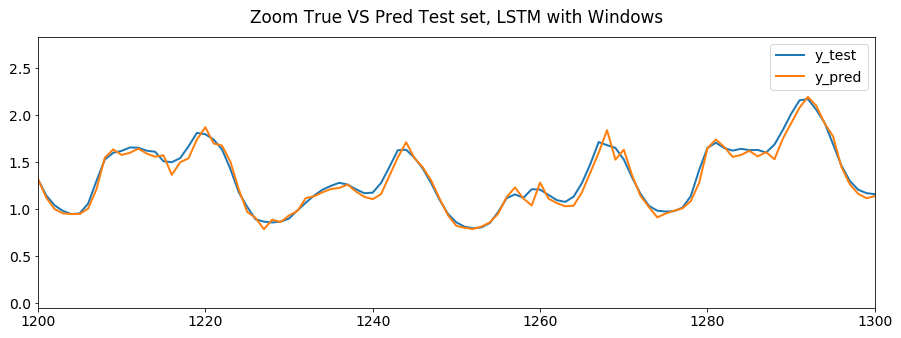

In [101]:
y_pred = model.predict(X_test_t, batch_size=256)
plt.figure(figsize=(15,5))
plt.plot(y_test_t, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.xlim(1200,1300)
plt.title("Zoom True VS Pred Test set, LSTM with Windows");

Let's check the loss and $R^2$ score:

In [102]:
mse = mean_squared_error(y_test_t, y_pred)
r2 = r2_score(y_test_t, y_pred)

print("MSE: {:0.3}".format(mse))
print("R2: {:0.3}".format(r2))

MSE: 0.0048
R2: 0.979


And the correlation:

In [103]:
y_test_s = pd.Series(y_test_t.ravel())
y_pred_s = pd.Series(y_pred.ravel())

for shift in range(-5, 5):
    y_pred_shifted = y_pred_s.shift(shift)
    corr = y_test_s.corr(y_pred_shifted)
    print("Shift: {:2}, Corr: {:0.2}".format(shift, corr))

Shift: -5, Corr: 0.5
Shift: -4, Corr: 0.63
Shift: -3, Corr: 0.76
Shift: -2, Corr: 0.88
Shift: -1, Corr: 0.97
Shift:  0, Corr: 0.99
Shift:  1, Corr: 0.94
Shift:  2, Corr: 0.84
Shift:  3, Corr: 0.72
Shift:  4, Corr: 0.58


This model trained considerably faster than the previous ones, and its predictions should look much better than the previous models. First of all the model seems to have learned the temporal patter much better than the other models: it's not simply repeating the input like a parrot, it's genuinely trying to predict the future. Also, the curves look quite close to one another, which is a great sign!

> TIP: Try to re-initialize and re-train the model if the loss of your model does not reach 0.05 and the above figure does not look like this:
![](./assets/lstm_ts_plot.png)
> One problem with recurrent models is that they tend to get stuck in local minima and be sensitive to initialization. Also, keep in mind that we chose only six units in this network, which is probably small for this problem.

### Conclusion

Well done! You have completed the lab on Time Series and Recurrent Neural Networks. Let's recap what we have learned.

1. We learned how to classify time series of a fixed length using both fully connected and convolutional Neural Networks
- We learned about recurrent Neural Networks and about how they allow us to approach new problems with sequences, including generating a sequence of arbitrary length and learning from sequences of arbitrary length
- We trained a fully connected network to forecast future values in a sequence
- We performed a deep dive in Recurrent Neural Networks, in particular in the Long Short-Term Memory network to see what advantage they bring
- Finally, we trained an LSTM model to forecast values using both a single point as well as a window of past data

Wow, this is a lot for a single lab!

In the exercises, we will explore a couple of extensions of what we have done, and we will try to predict the price of Bitcoin from its historical value!

## Exercises

### Exercise 1

Your manager at the power company is quite satisfied with the work you've done predicting the electric load of the next hour and would like to push it further. He is curious to know if your model can predict the load on the next day or even the next week instead of the next hour.

- Go ahead and use the helper function `create_lagged_Xy_win` we created above to generate new `X` and `y` pairs where the `start_lag` is 36 hours or even further. You may want to extend the window size to a little longer than a day.
- Train your best model on this data. You may have to use more than one layer. In which case, remember to use the `return_sequences=True` argument in all layers except for the last one so that they pass sequences to one another.
- Check the goodness of your model by comparing it with test data as well as looking at the $R^2$ score.

### Exercise 2

[Gate Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) (GRU) are a more modern and simpler implementation of a cell that retains longer term memory.

Their flow diagram is as follows:

![GRU network graph](./assets/gru.png)

Keras makes them available in `keras.layers.GRU`. Try swapping the LSTM layer with a GRU layer and re-train the model. Does its performance improve on the 36 hours lag task?

### Exercise 3

Does a fully connected model work well using Windows? Let's find out! Try to train a fully connected model on the lagged data with Windows, which will probably train much faster:

- reshape the input data back to an Order-2 tensor, i.e., eliminate the 3rd axis
- build a fully connected model with one or more layers
- train the fully connected model on the windowed data. Does it work well? Is it faster to train?

### Exercise 4

> Disclaimer: past performance is no guarantee of future results. This is not investment advice.

Predicting the price of Bitcoin from historical data.

You may have heard people talk about Bitcoin and how it is growing that you decide to put your newly acquired Deep Learning skills to test in trying to beat the market. The idea is simple: if we could predict what Bitcoin is going to do in the future, we can trade and profit using that knowledge.

The simplest formulation of this forecasting problem is to try to predict if the price of Bitcoin is going to go up or down in the future, i.e., we can frame the issue as a binary classification that answers the question: is Bitcoin going up.

Here are the steps to complete this exercise:

1. Load the data from `../data/poloniex_usdt_btc.json.gz` into a Pandas DataFrame. We obtained this data through the public API of the Poloniex cryptocurrency exchange.
- Check out the data using `df.head()`. Notice that the dataset contains the close, high, low, open for 30 minutes intervals, which means: the first, highest, lowest and last amounts of US Dollars people were willing to exchange Bitcoin for during those 30 minutes. The dataset also contains Volume values, that we shall ignore, and a weighted average value, which is what we will use to build the labels.
- Convert the date column to a datetime object using `pd.to_datetime` and set it as the index of the DataFrame.
- Plot the value of df['close'] to inspect the data. You will notice that it's not periodic at all and it has an overall enormous upward trend, so we will need to transform the data into a stationary time series. We will use percentage changes, i.e., we will look at relative movements in the price instead of absolute values.
- Create a new dataset `df_percent` with percent changes using the formula: 
\begin{equation}
v_t = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}}
\end{equation}
this is what we will use next.
- Inspect `df_percent` and notice that it contains both infinity and nan values. Drop the null values and replace the infinity values with zero.
- Split the data on January 1st, 2017, using the data before then as training and the data after that as the test.
- Use the window method to create an input training tensor `X_train_t` with the shape (n_windows, window_len, n_features). This is the main part of the exercise since you'll have to make a few choices and be careful not to leak information from the future. In particular, you will have to:
    - decide the window_len you want to use
    - decide which features you'd like to use as input (don't use `weightedAverage`, since we'll need it for the output.
    - decide what lag you want to introduce between the last timestep in your input window and the timestep of the output.
    - You can start from the `create_lagged_Xy_win` function we defined in Lab 7, but you will have to modify it to work with numpy arrays because Pandas DataFrames are only good with one feature.
- Create a binary outcome variable that is 1 when `train[weightedAverage] >= 0` and 0 otherwise. This variable is going to be our label.
- Repeat the same operations on the test data
- Create a model to work with this data. Make sure the input layer has the right `input_shape` and the output layer has one node with a Sigmoid activation function. Also, make sure to use the `binary_crossentropy` loss and to track the accuracy of the model.
- Train the model on the training data
- Test the model on the test data. Is the accuracy better than a baseline guess? Are you going to be rich?

> Again disclaimer: past performance is no guarantee of future results. This is not investment advice.